In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import gc
import argparse
import random
from box import Box
import cv2
import cvlib as cv
# import albumentations
import timm

In [2]:
# seed 고정
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# 데이터 전처리 함수

In [3]:
# ages 생성
def get_ages(x):
    if x < 30: return 0
    elif x < 60: return 1
    else: return 2

# genders 생성
def get_genders(x):
    if x == 'male': return 0
    else: return 1

# masks 생성
def get_masks(x):
    if x == 'normal': return 2
    elif x == 'incorrect_mask': return 1
    else: return 0

# age_cats 생성
def get_age_cats(x):
    if x < 20: return 0
    elif x < 30: return 1
    elif x < 40: return 2
    elif x < 50: return 3
    elif x < 60: return 4
    else: return 5

# labels 생성
def get_labels(masks, genders, ages):
    return masks * 6 + genders * 3 + ages

# label_cats 생성
def get_label_cats(masks, genders, ages):
    return masks * 12 + genders * 6 + ages

# 마스크 이상치 변경
def swap_mask(swap_li : list, df : pd.DataFrame) -> pd.DataFrame:
    swap_df = df.copy()
    for swap_id in swap_li:
        _swap_df = swap_df[swap_df['id'] == swap_id]
        
        normal_swap_df = _swap_df[_swap_df['mask'] == 'normal']
        incorrect_mask_swap_df = _swap_df[_swap_df['mask'] == 'incorrect_mask']
        
        normal_path = normal_swap_df['path'].values[0]
        incorrect_mask_path = incorrect_mask_swap_df['path'].values[0]
        
        swap_df.loc[normal_swap_df.index, 'path'] = incorrect_mask_path
        swap_df.loc[incorrect_mask_swap_df.index, 'path'] = normal_path
    
    return swap_df

# train_df + mask 결측치 처리
def make_train_df(df : pd.DataFrame, swap_mask_li : list, cfg) -> pd.DataFrame:
    train_df = []
    
    for line in df.iloc:
        for file in list(os.listdir(os.path.join(cfg.train_image_dir, line['path']))):
            if file[0] == '.':
                continue
            
            mask = file.split('.')[0]
            gender = line['gender']
            age = line['age']
            
            masks = get_masks(mask)
            genders = get_genders(gender)
            ages = get_ages(age)
            age_cats = get_age_cats(age)
            
            data = {
                'id' : line['id'],
                'mask' : mask,
                'gender' : gender,
                'age' : age,
                'masks' : masks,
                'genders' : genders,
                'ages' : ages,
                'age_cats' : age_cats,
                'labels': get_labels(masks = masks, genders = genders, ages = ages),
                'label_cats': get_label_cats(masks = masks, genders = genders, ages = age_cats),
                'path': os.path.join(cfg.train_image_dir, line['path'], file),
            }
            
            train_df.append(data)
            
    train_df = pd.DataFrame(train_df)
    
    train_df['idx'] = train_df.index
    train_df['transform'] = 0 # 적용할 transform 선택
    
    train_df = swap_mask(swap_li = swap_mask_li, df = train_df)
    
    return train_df

# 성별 이상치 처리
def swap_gender(swap_li : list, df : pd.DataFrame) -> pd.DataFrame:
    swap_df = df.copy()
    for swap in swap_li:
        swap_id, swap_gender = swap
        swap_df.loc[swap_df[swap_df['id'] == swap_id].index, 'gender'] = swap_gender
    return swap_df

# 사람 나누기 데이터 + 성별 결측치 처리
def preprocessing_df(df : pd.DataFrame, swap_gender_li : list) -> pd.DataFrame:
    
    preprocessing_df = df.copy()
    preprocessing_df = swap_gender(swap_li = swap_gender_li, df = preprocessing_df)
    
    preprocessing_df['ages'] = preprocessing_df['age'].apply(lambda x : get_ages(x))
    preprocessing_df['genders'] = preprocessing_df['gender'].apply(lambda x : get_genders(x))
    
    preprocessing_df['cv_taget_col'] = 'ages' + '_' + preprocessing_df['ages'].astype(str) + '_' + 'genders' + '_' + preprocessing_df['genders'].astype(str)
    
    return preprocessing_df

# 오버샘플링 함수

In [4]:
def transform_setting(train_df, sampling_list, target='labels'):
    df = train_df.copy()

    unsampling_df = df[~df[target].isin(sampling_list)]
    unsampling_df.reset_index(drop = True, inplace = True)
    
#     row_size = len(unsampling_df)
    
#     unsampling_df['transform'] = pd.DataFrame(np.random.randint(0, 2, size=(row_size, 1)), columns=['transform'], dtype=np.int64)
    unsampling_df['transform'] = 1
    
    return unsampling_df

## 오버 샘플링

def over_sampling(train_df, sampling_list, sampling_count_dict, target='labels'):
    df = train_df.copy()
    
    df = df[df[target].isin(sampling_list)] 
    
    sampling_df = pd.DataFrame()
    
    for key, value in sampling_count_dict.items():
        temp_df = df[df[target] == key]
        for count in range(value):
            temp_df['transform'] = 1
            sampling_df = pd.concat([sampling_df, temp_df], ignore_index=True)
    
    sampling_df.reset_index(drop = True, inplace = True)
    
    return sampling_df

# 이상치 시각화 함수

In [5]:
# 이상치 이미지 시각화
def show_img(img_id_li, df, cfg):
    for img_id in img_id_li:
        get_df = df[df['id'] == img_id]
        
        img_age = get_df['age'].tolist()[0]
        img_gender = get_df['gender'].tolist()[0]
        
        img_path = get_df['path'].tolist()[0]
        img_path = os.path.join(cfg.train_image_dir, img_path)
        img_name_li = sorted(list(os.listdir(img_path)))
        
        fig, ax = plt.subplots(1, 7, figsize = (30, 15))
        ax = ax.flatten()
        
        idx = 0
        for _img_name in img_name_li:
            if _img_name[0] == '.': continue
            
            if _img_name.split('.')[0] == 'normal': imag_name = 'normal'
            elif _img_name.split('.')[0] == 'incorrect_mask': imag_name = 'incorrect_mask'
            else: imag_name = 'mask'
            
            get_img_path = os.path.join(img_path, _img_name)
            
            img = Image.open(get_img_path)
            img = np.array(img)
            ax[idx].imshow(img)
            ax[idx].set_title(f'{img_id} / {img_age} / {img_gender} / {imag_name}')
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            idx += 1
            
        plt.show()

# image path로 이미지 시각화
def path_li_show_img(path_li):
    fig, ax = plt.subplots(1, 7, figsize = (30, 15))
    ax = ax.flatten()
    idx = 0
    for path in path_li:
        image_name = path.split('/')[-1]
        img = Image.open(path)
        img = np.array(img)
        ax[idx].imshow(img)
        ax[idx].set_title(f'{image_name}')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        idx += 1
    plt.show()

# 데이터 설정 함수

In [6]:
# val_idx 생성
def get_val_idx(df : pd.DataFrame, target_col : str):
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)
    for trn_idx, val_idx in skf.split(df, df[target_col]):
        yield val_idx

class CustomDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cfg, transform_list : list, mode : bool = True):
        self.mode = mode
        self.df = df
        if self.mode:
            self.img_paths = self.df['path'].tolist()
            self.targets = self.df[cfg.tagets_col].tolist()
            self.split_targets = self.df[cfg.split_col].tolist()
            self.transform_idx = self.df['transform'].tolist()
        else:
            self.img_paths = [os.path.join(cfg.submission_image_dir, img_id) for img_id in self.df.ImageID]
        self.transform = transform_list

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        
        if self.transform:
#             image = self.transform(image = np.array(image))['image']
            image = self.transform[0](image)
    
        # 이 부분에 해당 라벨에 따른 데이터 변환 여부 추가
        # val 데이터의 경우 데이터 변환이 일어나면 안되기 때문에
        # if self.데이터 변환해주는 transform:
        #     if self.targets[index].data == labels: <- 확률적으로
        #          image = self.데이터 변환해주는 transform(image)
        # 데이터 변환
        
        if self.mode:
            if self.transform_idx[index] != 0:
                image = self.transform[self.transform_idx[index]](image)
                
            targets = torch.tensor(self.targets[index])
            return image, targets
        
        else: return image

    def __len__(self):
        return len(self.img_paths)

class StratifiedSampler(torch.utils.data.Sampler):
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.cpu().numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits = n_batches, shuffle = shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)

# 모델

In [7]:
class CreateModel(nn.Module):
    def __init__(self, cfg , pretrained : bool = True):
        super(CreateModel, self).__init__()
        self.model = timm.create_model(cfg.timm_model_name, pretrained = pretrained, num_classes = cfg.num_classes)

    def forward(self, img):
        out = self.model(img)
        return out

# 스코어 함수

In [8]:
def get_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def get_acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [9]:
def model_train(model, optimizer, criterion, data_loader):
    model.train()
    
    train_loss = 0
    real_pred_li = []
    label_pred_li = []
    
    for images, targets in data_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # GA 추가시 아래 부분에 추가하기
        #############################
        
        benign_outputs = model(images)
        loss = criterion(benign_outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        predicted = benign_outputs.argmax(dim=-1)
        
        label_pred_li.extend(predicted.detach().cpu().numpy())
        real_pred_li.extend(targets.cpu().numpy())
        
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    train_loss /= len(data_loader)
    train_acc = get_acc_score(y_true = real_pred_li, y_pred = label_pred_li)
    train_fi_score = get_f1_score(y_true = real_pred_li, y_pred = label_pred_li)

    return train_loss, train_acc, train_fi_score

def model_eval(model, criterion, data_loader):
    model.eval()
    
    val_loss = 0
    real_pred_li = []
    label_pred_li = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device)

            benign_outputs = model(images)
            loss = criterion(benign_outputs, targets)

            val_loss += loss.item()

            predicted = benign_outputs.argmax(dim=-1)
        
            label_pred_li.extend(predicted.cpu().numpy())
            real_pred_li.extend(targets.cpu().numpy())
    
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    val_loss /= len(data_loader)
    val_acc = get_acc_score(y_true = real_pred_li, y_pred = label_pred_li)
    val_fi_score = get_f1_score(y_true = real_pred_li, y_pred = label_pred_li)
   
    return val_loss, val_acc, val_fi_score

In [10]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [11]:
def get_val_pred_li(model, data_loader):
    model.eval()
    real_pred_li = []
    label_pred_li = []
    ensemble_pred_li = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            output = model(images)
            
            label = output.argmax(dim=-1)
            label_pred_li.extend(label.cpu().numpy())
            
            ensemble_label = output.softmax(1)
            ensemble_pred_li.append(ensemble_label.cpu().numpy())
            
            real_pred_li.extend(targets.cpu().numpy())
            
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    return label_pred_li, np.concatenate(ensemble_pred_li), real_pred_li

def get_submission_pred_li(model, data_loader):
    model.eval()
    label_pred_li = []
    ensemble_pred_li = []
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            output = model(images)
            
            label = output.argmax(dim=-1)
            label_pred_li.extend(label.cpu().numpy())
            
            ensemble_label = output.softmax(1)
            ensemble_pred_li.append(ensemble_label.cpu().numpy())
            
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
    
    return label_pred_li, np.concatenate(ensemble_pred_li)

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


# https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

# 환경 설정

In [13]:
# 이상치 list
# swap_gender_li = ['id', '바꿀 성별']
# swap_mask_li = ['id']
swap_gender_li = [['006359', 'male'], ['006360', 'male'], ['006361', 'male'], ['006362', 'male'], 
                  ['006363', 'male'], ['006364', 'male'], ['001498-1', 'female'], ['004432', 'female']]
swap_mask_li = ['000020', '004418', '005227']

config = {
    'seed' : 22,
    
    'image_size' : [512, 384],
    'image_normal_mean' : [0.485, 0.456, 0.406],
    'image_normal_std' : [0.229, 0.224, 0.225],
    
    # oversampling
    'sampling_target' : 'labels',
    'sampling_list' : [2, 5] + [i for i in range(6, 18)], 
    'sampling_count' : {2 : 4, 5 : 3, 6 : 3, 7: 4, 8: 20, 9 : 2, 10 : 2, 11 : 13
                      , 12 : 3, 13 : 4, 14 : 20, 15 : 2, 16 : 2, 17 : 13},
    'transform_p' : 0.7,
    
    'crop_size' : 384,
    'blur_kernel_size' : (5, 9),
    'blur_sigma' : (0.1, 5),
    'brightness' : 0.5,
    'hue' : 0.3,
    'rotation' : 10,
    
    'num_workers' : 3,
    'epochs' : 30,
    'batch_size' : 128,
    'lr' : 0.00001,
    'oof' : 1,
    'num_classes' : 3,
    
#     cel
#     labelsmoothing
#     focal
#     f1
    'loss' : 'labelsmoothing',
    'smoothing' : 0.1,
    
    'train_data_name' : 'train.csv',
    'train_data_dir' : '/opt/ml/input/data/train',
    'train_image_dir' : '/opt/ml/input/data/train/images',
    
    'submission_data_name' : 'info.csv',
    'submission_data_dir' : '/opt/ml/input/data/eval',
    'submission_image_dir' : '/opt/ml/input/data/eval/images',
    'submission_dir' : './submission',
    
    
    'model_dir' : './model',
    # 저장할 모델병
    'model_name' : 'regnety_002_v28',
    
    # timm 에 존재하는 모델 이름
    'timm_model_name' : 'regnety_002',
    
    # 학습 타겟
    'tagets_col' : 'ages',
    'split_col' : 'label_cats',
    'cv_taget_col' : 'cv_taget_col',
    
    # 저장할 파일명
    'file_name' : 'regnety_002_v28.csv',
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

In [14]:
# 변환할 transform
# from albumentations import *
# from albumentations.pytorch import ToTensorV2

def image_face_crop(image, **kwargs):
    face, confidence = cv.detect_face(image)
    if not face : return image
    x, y, w, h = face[0]
    H, W, C = image.shape
    image = image[max(y - 100, 0) : min(h + 100, H), max(0 , x - 100) : min(w + 100, W)]
    return image

# 적용할 transform 목록 정의
transform_list = [
    transforms.Compose([
#     Resize(image_size, Image.BILINEAR),
    transforms.ToTensor(),
#     transforms.CenterCrop(config.crop_size),
    transforms.Normalize(mean=config.image_normal_mean, std=config.image_normal_std),
#     transforms.Grayscale(num_output_channels=3),
]),
    
    transforms.Compose([
    transforms.RandomApply(transforms = [transforms.ColorJitter(brightness=config.brightness, hue=config.hue)], p = config.transform_p),
    transforms.RandomApply(transforms = [transforms.GaussianBlur(kernel_size = config.blur_kernel_size, sigma = config.blur_sigma)], p = config.transform_p),
    transforms.RandomHorizontalFlip(p = config.transform_p),
#     transforms.RandomApply(transforms = [transforms.Grayscale(num_output_channels=3)], p = config.transform_p),
])
        
             
]

# transform = {
#         "train": transforms.Compose(
#             [
# #                 Lambda(image_face_crop),
# #                 ToPILImage(),
#                 Resize(config.image_size, Image.BILINEAR),
#                 ToTensor(),
# #                 RandomHorizontalFlip(p = 0.5),
#                 Normalize(mean=config.image_normal_mean, std=config.image_normal_std),
#             ]
#         ),  
#         "val": transforms.Compose(
#             [
#                 Resize(config.image_size, Image.BILINEAR),
#                 ToTensor(),
#                 Normalize(mean=config.image_normal_mean, std=config.image_normal_std),
#             ]
#         ),
#     }



# 데이터 로드

In [15]:
seed_everything(config.seed)

In [16]:
df = pd.read_csv(os.path.join(config.train_data_dir, config.train_data_name))
submission = pd.read_csv(os.path.join(config.submission_data_dir, config.submission_data_name))

# 이상치 시각화

In [28]:
# show_img(img_id_li =['000020', '004418', '005227', '006359', '006360', '006361', '006362', '006363', '006364', '001498-1'], df = df, cfg = config)

# 학습

In [17]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.cv_taget_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[val_id_df['id'].tolist(), :].reset_index()
    trn_df = train_df.set_index('id').loc[trn_id_df['id'].tolist(), :].reset_index()
    # 이 부분에 클래스가 적은 데이터 증강 함수 추가
    ########################################3
    

    unsampling_set = transform_setting(trn_df, sampling_list = config.sampling_list, target = config.sampling_target)
    
    sampling_set = over_sampling(trn_df, sampling_list = config.sampling_list, sampling_count_dict = config.sampling_count, target = config.sampling_target)
    
    trn_df = pd.concat([unsampling_set, sampling_set], ignore_index=True)

    # 배치 단위 데이터 생성 부분
    #########################
    
    
    # dataset 구축
    trn_dataset = CustomDataset(df = trn_df,
                                cfg = config,
                                transform_list = transform_list,
                                mode = True,
                               )
    
    train_loder = DataLoader(trn_dataset,
                           batch_size = config.batch_size,
                           num_workers = config.num_workers,
                           shuffle = True,
                            )
    
    
#     sampler = StratifiedSampler(y = np.array(trn_dataset.split_targets), 
#                                 batch_size = config.batch_size, 
#                                 shuffle = True)
    
#     train_loder = DataLoader(trn_dataset,
#                              num_workers = config.num_workers,
#                              batch_sampler = sampler)
    
    
    val_dataset = CustomDataset(df = val_df,
                                cfg = config,
                                transform_list = transform_list,
                                mode = True,)
    
    val_loder = DataLoader(val_dataset,
                           batch_size = config.batch_size,
                           num_workers = config.num_workers,
                           shuffle = False,)
    
    # 모델 정의
    model = CreateModel(cfg = config, pretrained = True).to(device)

    # loss 설정
    if config.loss == 'cel':
        criterion = nn.CrossEntropyLoss()
    elif config.loss == 'labelsmoothing':
        criterion = LabelSmoothingLoss(classes=config.num_classes, smoothing = config.smoothing, dim=-1)
    elif config.loss == 'focal':
        criterion = FocalLoss(weight=None, gamma=2., reduction='mean')
    elif config.loss == 'f1':
        criterion = F1Loss(classes=config.num_classes, epsilon=1e-7)
    else:
        print('not loss')
    
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, amsgrad=True)
    
    # scheduler 설정
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 5)
   
    # besf_metric 설정
    min_val_loss = float("inf")
    early_stopping_count = 0
    
    for epoch in tqdm(range(1, config.epochs + 1)):
        epoch_start_time = time.time()
        
        train_loss, train_acc, train_fi_score = model_train(model = model, 
                                                            optimizer = optimizer, 
                                                            criterion = criterion, 
                                                            data_loader = train_loder)
        
        val_loss, val_acc, val_fi_score, = model_eval(model = model,
                                                      criterion = criterion,
                                                      data_loader = val_loder)
        
        # 학습률
        now_lr = get_lr(optimizer = optimizer)
        
        epoch_end_time = time.time()
        
        print(f'''{fold_num}fold, epoch: {epoch}, lr: {now_lr}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, train_f1: {train_fi_score:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, val_fi: {val_fi_score:.4f}, 학습시간: {epoch_end_time - epoch_start_time} \n''')

        # 스케줄러
        scheduler.step(val_loss)
        
        # 모델 저장
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(config.model_dir, f'{fold_num}fold_{config.model_name}.pt'))
            print(val_loss, '모델 저장')
            early_stopping_count = 0
        else:
            early_stopping_count += 1
            if early_stopping_count == 10:
                print('early_stopping')
                break
            
        # 모델 저장
#         if besf_fi < val_loss:
#             besf_fi = val_fi_score
#             torch.save(model.state_dict(), os.path.join(config.model_dir, f'{fold_num}fold_{config.model_name}.pt'))
#             print(besf_fi, '모델 저장')
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

  3%|▎         | 1/30 [06:06<2:57:14, 366.71s/it]

1fold, epoch: 1, lr: 1e-05, train_loss: 0.9931, train_acc: 0.5943, train_f1: 0.5943, val_loss: 0.8327, val_acc: 0.7923, val_fi: 0.6845, 학습시간: 366.66944313049316 

0.8326624194780986 모델 저장


  7%|▋         | 2/30 [12:14<2:51:20, 367.17s/it]

1fold, epoch: 2, lr: 1e-05, train_loss: 0.7753, train_acc: 0.7666, train_f1: 0.7594, val_loss: 0.6784, val_acc: 0.8209, val_fi: 0.7255, 학습시간: 368.1453537940979 

0.6783702373504639 모델 저장


 10%|█         | 3/30 [18:21<2:45:08, 366.97s/it]

1fold, epoch: 3, lr: 1e-05, train_loss: 0.6700, train_acc: 0.8224, train_f1: 0.8181, val_loss: 0.6284, val_acc: 0.8415, val_fi: 0.7384, 학습시간: 366.4068353176117 

0.6283998837073644 모델 저장


 13%|█▎        | 4/30 [24:29<2:39:06, 367.16s/it]

1fold, epoch: 4, lr: 1e-05, train_loss: 0.6183, train_acc: 0.8572, train_f1: 0.8542, val_loss: 0.6037, val_acc: 0.8534, val_fi: 0.7450, 학습시간: 367.52520990371704 

0.6036501109600068 모델 저장


 17%|█▋        | 5/30 [30:28<2:31:58, 364.75s/it]

1fold, epoch: 5, lr: 1e-05, train_loss: 0.5842, train_acc: 0.8823, train_f1: 0.8800, val_loss: 0.5963, val_acc: 0.8553, val_fi: 0.7499, 학습시간: 359.05198979377747 

0.5963144769271215 모델 저장


 20%|██        | 6/30 [36:41<2:26:52, 367.17s/it]

1fold, epoch: 6, lr: 1e-05, train_loss: 0.5556, train_acc: 0.9009, train_f1: 0.8994, val_loss: 0.5855, val_acc: 0.8606, val_fi: 0.7442, 학습시간: 372.73765993118286 

0.5854939103126526 모델 저장


 23%|██▎       | 7/30 [42:40<2:19:53, 364.95s/it]

1fold, epoch: 7, lr: 1e-05, train_loss: 0.5339, train_acc: 0.9173, train_f1: 0.9163, val_loss: 0.5892, val_acc: 0.8622, val_fi: 0.7535, 학습시간: 359.77623319625854 



 27%|██▋       | 8/30 [48:45<2:13:50, 365.02s/it]

1fold, epoch: 8, lr: 1e-05, train_loss: 0.5148, train_acc: 0.9292, train_f1: 0.9288, val_loss: 0.5828, val_acc: 0.8701, val_fi: 0.7578, 학습시간: 365.0994780063629 

0.5828079760074616 모델 저장


 30%|███       | 9/30 [54:46<2:07:16, 363.64s/it]

1fold, epoch: 9, lr: 1e-05, train_loss: 0.4992, train_acc: 0.9392, train_f1: 0.9389, val_loss: 0.5846, val_acc: 0.8669, val_fi: 0.7504, 학습시간: 360.4098107814789 



 33%|███▎      | 10/30 [1:00:52<2:01:28, 364.41s/it]

1fold, epoch: 10, lr: 1e-05, train_loss: 0.4893, train_acc: 0.9466, train_f1: 0.9466, val_loss: 0.5812, val_acc: 0.8751, val_fi: 0.7512, 학습시간: 366.13805055618286 

0.5811507076025009 모델 저장


 37%|███▋      | 11/30 [1:07:06<1:56:17, 367.26s/it]

1fold, epoch: 11, lr: 1e-05, train_loss: 0.4773, train_acc: 0.9548, train_f1: 0.9549, val_loss: 0.5840, val_acc: 0.8733, val_fi: 0.7570, 학습시간: 373.882728099823 



 40%|████      | 12/30 [1:13:28<1:51:32, 371.80s/it]

1fold, epoch: 12, lr: 1e-05, train_loss: 0.4705, train_acc: 0.9576, train_f1: 0.9580, val_loss: 0.5874, val_acc: 0.8783, val_fi: 0.7619, 학습시간: 382.38892579078674 



 43%|████▎     | 13/30 [1:19:47<1:45:55, 373.86s/it]

1fold, epoch: 13, lr: 1e-05, train_loss: 0.4626, train_acc: 0.9630, train_f1: 0.9633, val_loss: 0.5866, val_acc: 0.8807, val_fi: 0.7621, 학습시간: 378.68289971351624 



 47%|████▋     | 14/30 [1:26:04<1:39:57, 374.87s/it]

1fold, epoch: 14, lr: 1e-05, train_loss: 0.4571, train_acc: 0.9684, train_f1: 0.9689, val_loss: 0.5876, val_acc: 0.8796, val_fi: 0.7666, 학습시간: 377.222425699234 



 50%|█████     | 15/30 [1:32:22<1:33:57, 375.86s/it]

1fold, epoch: 15, lr: 1e-05, train_loss: 0.4535, train_acc: 0.9695, train_f1: 0.9701, val_loss: 0.5864, val_acc: 0.8849, val_fi: 0.7707, 학습시간: 378.1778311729431 



 53%|█████▎    | 16/30 [1:38:45<1:28:11, 377.99s/it]

1fold, epoch: 16, lr: 1e-05, train_loss: 0.4468, train_acc: 0.9737, train_f1: 0.9743, val_loss: 0.5828, val_acc: 0.8870, val_fi: 0.7721, 학습시간: 382.93645906448364 



 57%|█████▋    | 17/30 [1:45:00<1:21:38, 376.83s/it]

1fold, epoch: 17, lr: 1.0000000000000002e-06, train_loss: 0.4418, train_acc: 0.9759, train_f1: 0.9765, val_loss: 0.5818, val_acc: 0.8881, val_fi: 0.7758, 학습시간: 374.135057926178 



 60%|██████    | 18/30 [1:51:11<1:15:03, 375.28s/it]

1fold, epoch: 18, lr: 1.0000000000000002e-06, train_loss: 0.4434, train_acc: 0.9759, train_f1: 0.9764, val_loss: 0.5877, val_acc: 0.8847, val_fi: 0.7765, 학습시간: 371.6534857749939 



 63%|██████▎   | 19/30 [1:57:21<1:08:30, 373.67s/it]

1fold, epoch: 19, lr: 1.0000000000000002e-06, train_loss: 0.4429, train_acc: 0.9765, train_f1: 0.9770, val_loss: 0.5842, val_acc: 0.8862, val_fi: 0.7665, 학습시간: 369.90346574783325 



 63%|██████▎   | 19/30 [2:03:32<1:11:31, 390.13s/it]

1fold, epoch: 20, lr: 1.0000000000000002e-06, train_loss: 0.4417, train_acc: 0.9766, train_f1: 0.9772, val_loss: 0.5841, val_acc: 0.8862, val_fi: 0.7740, 학습시간: 370.8288240432739 

early_stopping
1fold 훈련 시간: 7417.191113471985 



총 훈련 시간: 7417.413154125214


# 평가

In [18]:
# submission 데이터 정의
submission_dataset = CustomDataset(df = submission, 
                                   cfg = config,
                                   transform_list = transform_list,
                                   mode = False,
                                  )

submission_loder = DataLoader(submission_dataset,
                                batch_size = config.batch_size,
                                num_workers = config.num_workers,
                                shuffle = False,
                             )

submission_label_oof = np.zeros((submission.shape[0], config.num_classes))

pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.cv_taget_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in tqdm(range(1, config.oof + 1)):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[val_id_df['id'].tolist(), :].reset_index()
    trn_df = train_df.set_index('id').loc[trn_id_df['id'].tolist(), :].reset_index()
    
    val_dataset = CustomDataset(df = val_df, 
                                cfg = config,
                                transform_list = transform_list,
                                mode = True,
                               )
    
    val_loder = DataLoader(val_dataset,
                            batch_size = config.batch_size,
                           num_workers = config.num_workers,
                            shuffle = False,)
    
    # 모델 로드
    model = CreateModel(cfg = config, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.model_dir, f'{fold_num}fold_{config.model_name}.pt')))
    
    # val 평가
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loder)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    # submission 평가
    submission_label_pred_li, submission_ensemble_pred_li = get_submission_pred_li(model = model, data_loader = submission_loder)
    submission_label_oof += submission_ensemble_pred_li / config.oof
    
    fold_end_time = time.time()

    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)

    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

# pred_li = submission_label_oof.argmax(1).tolist()
# pred_li = [label_cats2labels[i] for i in pred_li]
# submission['ans'] = pred_li

submission['ans'] = submission_label_oof.argmax(1).tolist()

100%|██████████| 1/1 [00:37<00:00, 37.95s/it]

1fold 훈련 시간: 37.938788414001465, acc: 0.8751322751322751, f1_score: 0.751182540240734 



In [19]:
submission_label_oof

array([[0.03389685, 0.80204511, 0.16405803],
       [0.09261733, 0.83401525, 0.07336741],
       [0.05219801, 0.89094925, 0.05685269],
       ...,
       [0.81916374, 0.13155256, 0.04928368],
       [0.21094981, 0.75362611, 0.03542404],
       [0.11712804, 0.81453043, 0.06834157]])

In [20]:
submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,1
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,1
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,1
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,1
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,0
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


In [21]:
submission['ans'].value_counts()

0    5389
1    5302
2    1909
Name: ans, dtype: int64

## Age_Cats to Age

In [22]:
# submission age target 변경
def age_cats_to_target(x):
    if x <= 1: return 0
    elif x <= 4: return 1
    else: return 2

In [23]:
submission['ans'] = submission['ans'].apply(age_cats_to_target)

In [24]:
submission['ans'].value_counts()

1    6274
0    5423
2     903
Name: ans, dtype: int64

In [25]:
submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,1
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,1
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,1
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,0
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


# 결과

In [22]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

train confusion_matrix


,0,1,2
0,1706,86,0
1,108,1491,123
2,0,155,111


train fi : 0.7512, train acc: 0.8751 



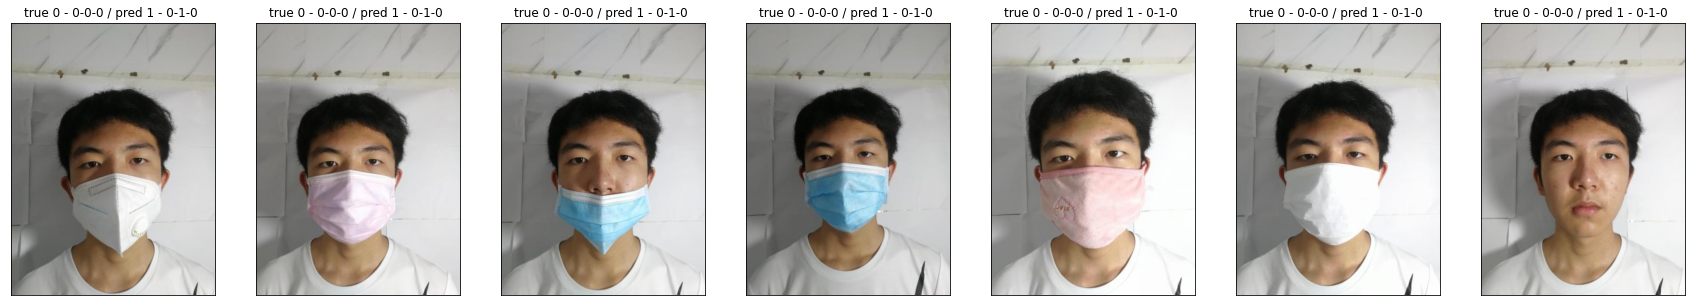

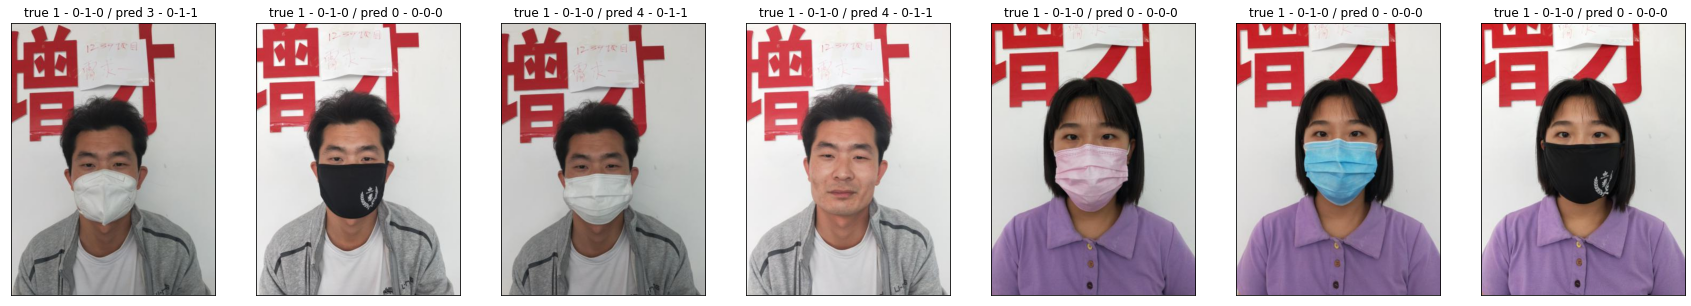

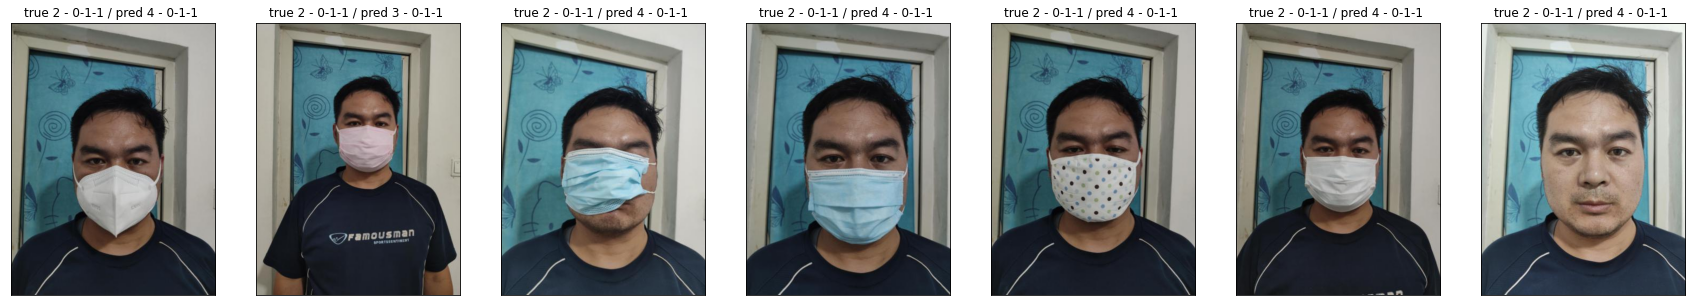

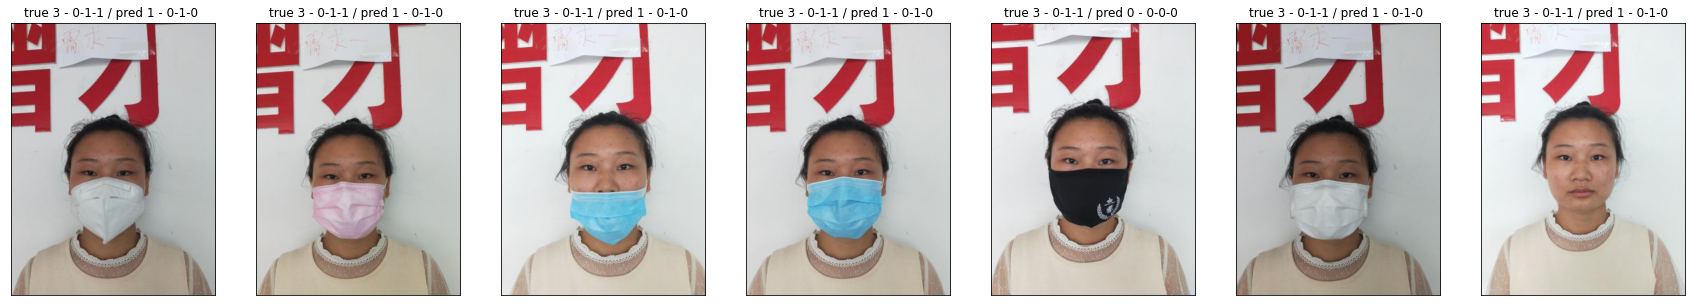

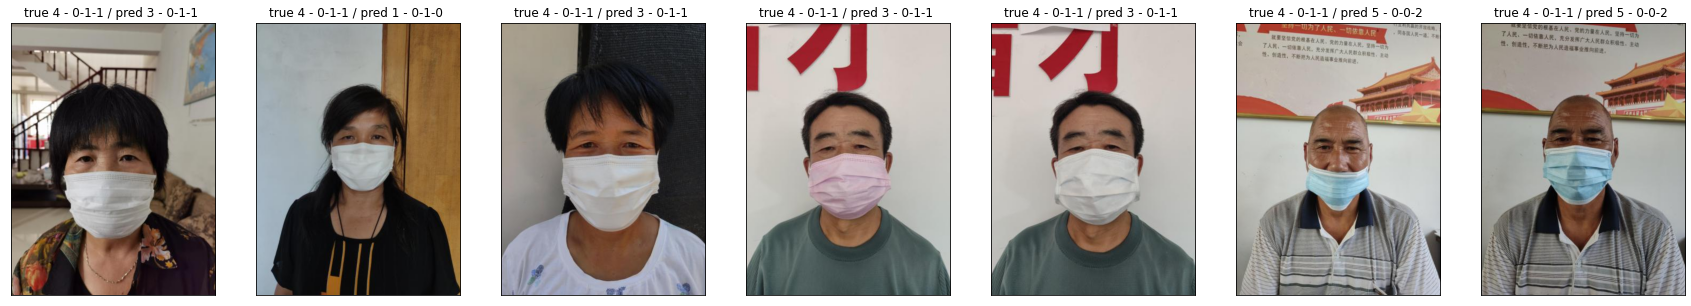

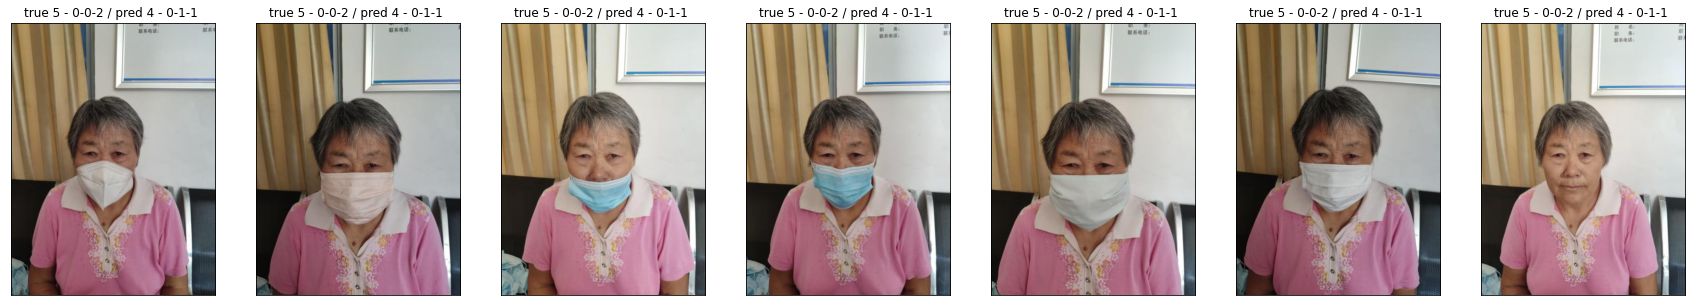

In [27]:
# labels 로 masks, genders, ages 역추적
labels2masks_genders_ages = {}
for line in train_df[~(train_df.duplicated(subset=[config.tagets_col]))].iloc:
    labels2masks_genders_ages[line[config.tagets_col]] = str(line['masks']) + '-' + str(line['genders']) + '-' + str(line['ages'])

# 틀린 이미지 시각화
image_show_df = train_df.iloc[idx_li, :].reset_index(drop =True)
image_show_df['pred_labels'] = pred_labels
false_image_show_df = image_show_df[image_show_df[config.tagets_col] != image_show_df['pred_labels']]
labels_li = [i for i in range(config.num_classes)]
for labels in labels_li:
    _false_image_show_df = false_image_show_df[false_image_show_df[config.tagets_col] == labels]
    path_labels_pred_labels_li = _false_image_show_df[['path', config.tagets_col, 'pred_labels']].values[:7]
    
    idx = 0
    fig, ax = plt.subplots(1, 7, figsize = (30, 15))
    ax = ax.flatten()
    for path_labels_pred_labels in path_labels_pred_labels_li:
        img = Image.open(path_labels_pred_labels[0])
        img = np.array(img)
        ax[idx].imshow(img)
        ax[idx].set_title(f'true {path_labels_pred_labels[1]} - {labels2masks_genders_ages[path_labels_pred_labels[1]]} / pred {path_labels_pred_labels[2]} - {labels2masks_genders_ages[path_labels_pred_labels[2]]} ')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        idx += 1
    plt.show()

# 저장

In [23]:
submission.to_csv(os.path.join(config.submission_dir, config.file_name), index=False)
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,1
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,1
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,1
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


# 앙상블

In [20]:
pred_df = pd.DataFrame()
pred_df['masks'] = pred_labels
pred_df.to_csv(os.path.join(config.submission_dir, f'{config.timm_model_name}_masks.csv'))
pred_df.head()

,masks
0,2
1,0
2,0
3,0
4,0


In [21]:
pred_ages_df = pd.read_csv(os.path.join(config.submission_dir, f'{config.timm_model_name}_ages.csv'))
pred_genders_df = pd.read_csv(os.path.join(config.submission_dir, f'{config.timm_model_name}_genders.csv'))
pred_masks_df = pd.read_csv(os.path.join(config.submission_dir, f'{config.timm_model_name}_masks.csv'))

In [22]:
def get_labels(masks, genders, ages):
    return masks * 6 + genders * 3 + ages

pred_li = []
for masks_line, genders_line, ages_line in zip(pred_masks_df.iloc, pred_genders_df.iloc, pred_ages_df.iloc):
    pred_li.append(get_labels(masks_line['masks'], genders_line['genders'], ages_line['ages']))

pred_df = pd.DataFrame()
pred_df['labels'] = pred_li

In [23]:
real_labels = train_df.iloc[idx_li, :].reset_index(drop =True)['labels'].tolist()
pred_labels = pred_df['labels'].tolist()

In [24]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

train confusion_matrix


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2644,97,0,22,5,0,2,0,0,0,0,0,0,0,0,0,0,0
1,83,1791,139,5,25,4,0,1,1,0,1,0,0,0,0,0,0,0
2,0,191,222,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
3,33,4,0,3425,181,0,0,0,0,2,0,0,0,0,0,0,0,0
4,0,22,0,113,3796,151,0,0,0,0,2,1,0,0,0,0,0,0
5,0,2,1,0,205,336,0,0,0,0,0,1,0,0,0,0,0,0
6,4,1,0,0,0,0,526,18,0,5,0,0,0,0,0,0,0,0
7,0,3,1,0,0,0,15,356,26,2,5,2,0,0,0,0,0,0
8,0,0,0,0,0,0,0,39,44,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,7,1,0,692,29,0,0,0,0,0,0,0


train fi : 0.8187, train acc: 0.9041 



In [25]:
config.submission_data_name

'info.csv'

In [24]:
submission_df = pd.read_csv(os.path.join(config.submission_dir, config.submission_data_name))
sub_ages_df = pd.read_csv(os.path.join(config.submission_dir, f'{config.timm_model_name}_ages.csv'))
sub_genders_df = pd.read_csv(os.path.join(config.submission_dir, f'{config.timm_model_name}_genders.csv'))
sub_masks_df = pd.read_csv(os.path.join(config.submission_dir, f'{config.timm_model_name}_masks.csv'))

In [25]:
def get_labels(masks, genders, ages):
    return masks * 6 + genders * 3 + ages

pred_li = []
for masks_line, genders_line, ages_line in zip(sub_masks_df.iloc, sub_genders_df.iloc, sub_ages_df.iloc):
    pred_li.append(get_labels(masks_line['ans'], genders_line['ans'], ages_line['ans']))

In [26]:
submission_df['ans'] = pred_li

In [27]:
submission_df.to_csv(os.path.join(config.submission_dir, 'ages_genders_masks_ensemble.csv'), index=False)
submission_df.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12
